In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow import keras

2024-05-12 12:35:33.714588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 12:35:34.641441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64:/usr/local/cuda/lib64/openmpi:/apps/gcc/mpi/openmpi/3.0.0/lib64:/apps/gcc/mpi/openmpi/3.0.0/lib64/openmpi:/apps/gcc/compiler/mpich/3.4.2/lib64:/apps/gcc/compiler/mpich/3.4.2/lib64/openmpi:/home/cs20b1006/miniconda3/envs/GO_IQA_DE_CNN/lib/:/usr/local/cuda/lib64:/usr/local/cuda/lib64/openmpi:/apps/gcc/compiler/mpich/3.4.2/lib64:/apps/gcc/compiler/mpich/3.4.2/lib64/openmpi:/apps

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

In [3]:
# loading the data
data = pd.read_csv('datasets/nyu_data/selected/selected_5000_mse.csv')

In [4]:
# adding datasets/nyu_data/selected/ to all the cells of columns images and depths
data['images'] = 'datasets/nyu_data/selected/' + data['images']
data['depths'] = 'datasets/nyu_data/selected/' + data['depths']

In [5]:
data.head()

,images,depths,mse
0,datasets/nyu_data/selected/colours/172.jpg,datasets/nyu_data/selected/depth/172.png,0.049538
1,datasets/nyu_data/selected/colours_blurred/5_5...,datasets/nyu_data/selected/depth/49.png,0.068819
2,datasets/nyu_data/selected/colours_noisy/0_08/...,datasets/nyu_data/selected/depth/8.png,0.049201
3,datasets/nyu_data/selected/colours_noisy/0_08/...,datasets/nyu_data/selected/depth/00810_depth.png,0.111913
4,datasets/nyu_data/selected/colours_noisy/0_01/...,datasets/nyu_data/selected/depth/485.png,0.161699


In [6]:
# min max normalizing the mse values
data['mse'] = (data['mse'] - data['mse'].min()) / (data['mse'].max() - data['mse'].min())

In [7]:
data.head()

,images,depths,mse
0,datasets/nyu_data/selected/colours/172.jpg,datasets/nyu_data/selected/depth/172.png,0.109200
1,datasets/nyu_data/selected/colours_blurred/5_5...,datasets/nyu_data/selected/depth/49.png,0.156157
2,datasets/nyu_data/selected/colours_noisy/0_08/...,datasets/nyu_data/selected/depth/8.png,0.108378
3,datasets/nyu_data/selected/colours_noisy/0_08/...,datasets/nyu_data/selected/depth/00810_depth.png,0.261113
4,datasets/nyu_data/selected/colours_noisy/0_01/...,datasets/nyu_data/selected/depth/485.png,0.382365


In [8]:
import seaborn as sns

<Axes: xlabel='mse', ylabel='Count'>

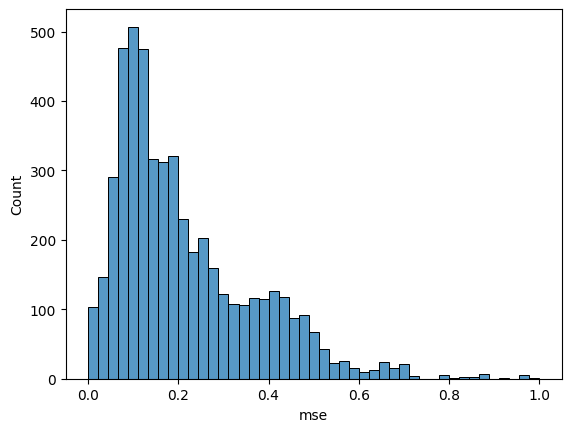

In [9]:
# plotting the distribution of the mse values
sns.histplot(data['mse'])

In [10]:
df = data

In [11]:
# Function to preprocess images
def load_and_preprocess_image(path):
    img = image.load_img(path, target_size=(224, 224))  # ResNet50 default input size
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

In [12]:
# Dataset preparation
def prepare_dataset(df):
    image_data = np.vstack([load_and_preprocess_image(x) for x in df['images']])
    scores = df['mse'].values
    return image_data, scores

In [13]:
# Splitting the dataframe into training and validation
train_df = df.sample(frac=0.8, random_state=200)  # 80% for training
valid_df = df.drop(train_df.index)  # Remaining 20% for validation

In [14]:
# Prepare data
train_images, train_scores = prepare_dataset(train_df)
valid_images, valid_scores = prepare_dataset(valid_df)

In [72]:
# Model creation
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = True  # Make all layers trainable

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)  # First additional dense layer
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(256, activation='relu')(x)  # Second additional dense layer
output = Dense(1, activation='linear')(x)  # Linear activation for regression
model = Model(inputs=base_model.input, outputs=output)

In [95]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [73]:
# Model compilation
model.compile(optimizer='adam', loss='mse')

In [74]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [82]:
# Model training
history = model.fit(train_images, train_scores, validation_data=(valid_images, valid_scores), epochs=50, callbacks=[early_stopping])

Epoch 1/50
125/125 [==============================] - 11s 88ms/step - loss: 0.0142 - val_loss: 0.0185
Epoch 2/50
125/125 [==============================] - 9s 72ms/step - loss: 0.0095 - val_loss: 0.0129
Epoch 3/50
125/125 [==============================] - 9s 71ms/step - loss: 0.0060 - val_loss: 0.0139
Epoch 4/50
125/125 [==============================] - 9s 74ms/step - loss: 0.0046 - val_loss: 0.0104
Epoch 5/50
125/125 [==============================] - 9s 72ms/step - loss: 0.0034 - val_loss: 0.0111
Epoch 6/50
125/125 [==============================] - 9s 70ms/step - loss: 0.0024 - val_loss: 0.0123
Epoch 7/50
125/125 [==============================] - 11s 89ms/step - loss: 0.0022 - val_loss: 0.0107
Epoch 8/50
125/125 [==============================] - 19s 154ms/step - loss: 0.0020 - val_loss: 0.0113
Epoch 9/50
125/125 [==============================] - 18s 146ms/step - loss: 0.0017 - val_loss: 0.0104
Epoch 10/50
125/125 [==============================] - 18s 146ms/step - loss: 0.0017 

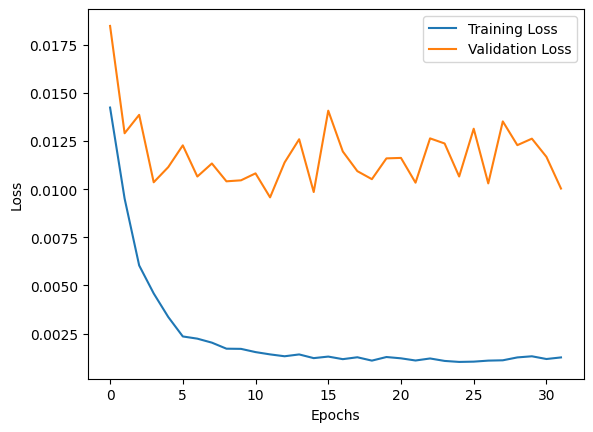

In [83]:
# plotting the training and validation loss
history = model.history.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [87]:
y_pred = model.predict(valid_images)

32/32 [==============================] - 1s 23ms/step


In [88]:
# getting the mae and mse between the predicted and actual values
mae = np.mean(np.abs(valid_scores - y_pred))
mse = np.mean((valid_scores - y_pred)**2)
print(f'MAE: {mae}, MSE: {mse}')

MAE: 0.13103935378164633, MSE: 0.02983325125554004


In [89]:
# getting the pearson correlation between the predicted and actual values
pearson_corr = np.corrcoef(valid_scores, y_pred.flatten())[0, 1]
print(f'Pearson Correlation: {pearson_corr}')

Pearson Correlation: 0.8933442751150932


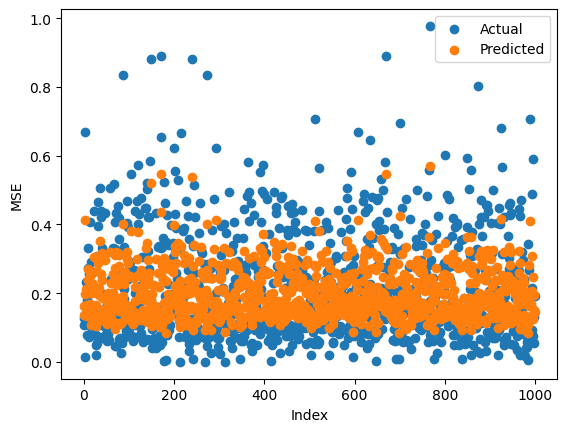

In [90]:
# getting scatter plot of actual vs predicted values with x axis being just the index and y axis being the actual and predicted values
plt.scatter(range(len(valid_scores)), valid_scores, label='Actual')
plt.scatter(range(len(y_pred)), y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

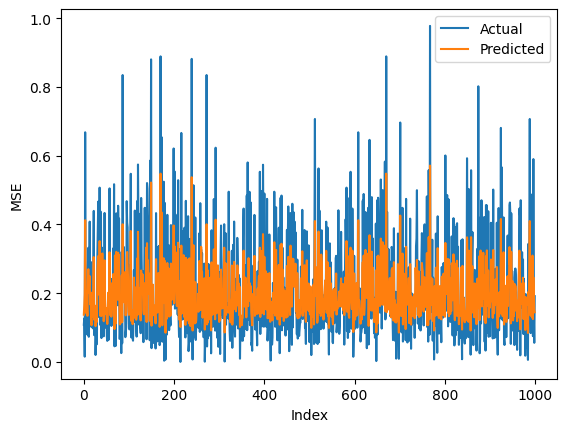

In [91]:
# plotting a line plot of the actual and predicted values
plt.plot(valid_scores, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [92]:
# get r2 score
from sklearn.metrics import r2_score
r2_score(valid_scores, y_pred)

0.6036139674771464

In [93]:
# Saving the model
model.save('Custom_Resnet50.h5')

In [46]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np

In [96]:
def create_model():
    # Load ResNet152 with pre-trained ImageNet weights
    base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Additional dense layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout to prevent overfitting
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)  # More dense layers
    output = Dense(1, activation='linear')(x)  # Output layer for regression

    model = Model(inputs=base_model.input, outputs=output)
    return model


In [97]:
# Prepare the model
model = create_model()

In [98]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block6_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block6_2_relu[0][0]']    
                                                                                                  
 conv3_block6_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block6_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block8_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
          

                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block10_1_relu[0][0]']   
                                                                                                  
 conv4_block10_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_2_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block13_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block13_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block13_1_relu[0][0]']   
                                                                                                  
 conv4_block13_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block13_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block13_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_2_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block16_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block16_1_relu[0][0]']   
                                                                                                  
 conv4_block16_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block16_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block19_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block19_1_relu[0][0]']   
                                                                                                  
 conv4_block19_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block22_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block22_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block22_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block22_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block22_1_relu[0][0]']   
                                                                                                  
 conv4_block22_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_2_conv[0][0]']   
 lization)

 conv4_block25_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block24_out[0][0]']      
                                                                                                  
 conv4_block25_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block25_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block28_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block27_out[0][0]']      
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block28_1_relu[0][0]']   
          

                                )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block30_out[0][0]']      
                                                                                                  
 conv4_block31_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block31_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block31_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block31_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block33_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block34_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block33_out[0][0]']      
                                                                                                  
 conv4_block34_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block34_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block34_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block34_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block36_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block36_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block36_out[0][0]']      
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)       

                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_5 (Gl  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_20 (Dense)               (None, 1024)         2098176     ['global_average_pooling2d_5[0][0
                                                                 ]']                              
                                                                                                  
 dropout_6

In [49]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [50]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [52]:
# Model training
history = model.fit(train_images, train_scores, validation_data=(valid_images, valid_scores), epochs=50, callbacks=[early_stopping])

Epoch 1/50
125/125 [==============================] - 26s 205ms/step - loss: 0.6117 - val_loss: 0.1225
Epoch 2/50
125/125 [==============================] - 23s 181ms/step - loss: 0.0199 - val_loss: 0.0182
Epoch 3/50
125/125 [==============================] - 24s 192ms/step - loss: 0.0138 - val_loss: 0.0144
Epoch 4/50
125/125 [==============================] - 23s 185ms/step - loss: 0.0097 - val_loss: 0.0136
Epoch 5/50
125/125 [==============================] - 33s 262ms/step - loss: 0.0072 - val_loss: 0.0093
Epoch 6/50
125/125 [==============================] - 41s 332ms/step - loss: 0.0059 - val_loss: 0.0108
Epoch 7/50
125/125 [==============================] - 42s 333ms/step - loss: 0.0040 - val_loss: 0.0077
Epoch 8/50
125/125 [==============================] - 41s 329ms/step - loss: 0.0031 - val_loss: 0.0064
Epoch 9/50
125/125 [==============================] - 41s 328ms/step - loss: 0.0032 - val_loss: 0.0057
Epoch 10/50
125/125 [==============================] - 38s 304ms/step - l

In [53]:
# Saving the model
model.save('Custom_Resnet150.h5')

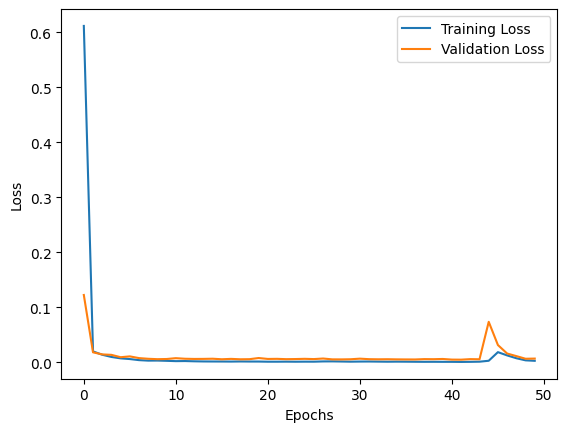

In [54]:
# plotting the training and validation loss
history = model.history.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
y_pred = model.predict(valid_images)

32/32 [==============================] - 5s 69ms/step


In [56]:
# getting the mae and mse between the predicted and actual values
mae = np.mean(np.abs(valid_scores - y_pred))
mse = np.mean((valid_scores - y_pred)**2)
print(f'MAE: {mae}, MSE: {mse}')

MAE: 0.15515100835348133, MSE: 0.041318492717616576


In [57]:
# getting the pearson correlation between the predicted and actual values
pearson_corr = np.corrcoef(valid_scores, y_pred.flatten())[0, 1]
print(f'Pearson Correlation: {pearson_corr}')

Pearson Correlation: 0.8547062109862537


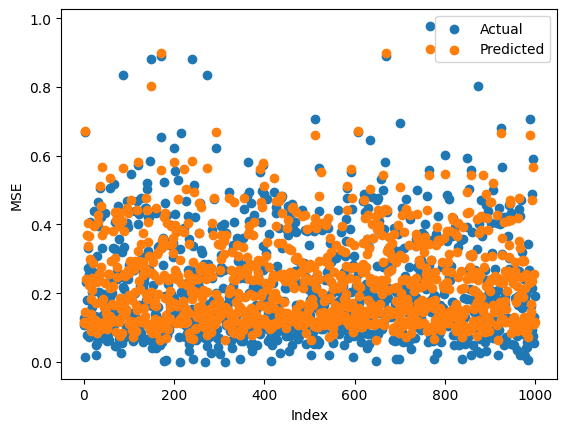

In [58]:
# getting scatter plot of actual vs predicted values with x axis being just the index and y axis being the actual and predicted values
plt.scatter(range(len(valid_scores)), valid_scores, label='Actual')
plt.scatter(range(len(y_pred)), y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

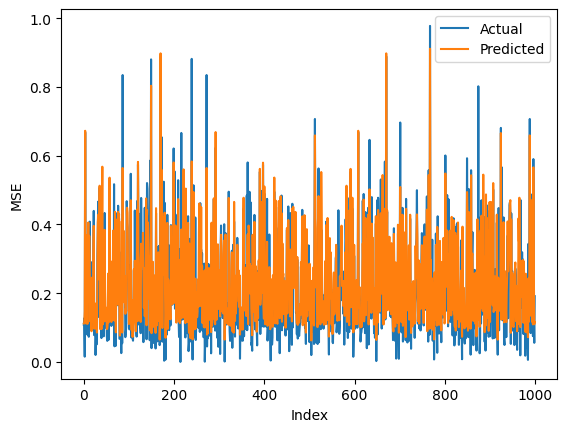

In [59]:
# plotting a line plot of the actual and predicted values
plt.plot(valid_scores, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [60]:
# get r2 score
from sklearn.metrics import r2_score
r2_score(valid_scores, y_pred)

0.7191525031686936